In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training_path = 'ml-100k/ua.base'
validation_path = 'ml-100k/ua.test'
#读取训练集和测试集
training_set = pd.read_csv(training_path,sep='\t',names=['user_id','item_id','rating','timestamp'])
validation_set = pd.read_csv(validation_path,sep='\t',names=['user_id','item_id','rating','timestamp'])
#填充评分矩阵
n_users = np.max(training_set['user_id'].unique())
n_items = np.max(training_set['item_id'].unique())
R = np.zeros((n_users,n_items))
validation_R = np.zeros(R.shape)
for row in training_set.itertuples(index=False):
    R[row.user_id-1][row.item_id-1] = row.rating
for row in validation_set.itertuples(index=False):
    validation_R[row.user_id-1][row.item_id-1] = row.rating

In [3]:
#损失函数
def mse_loss(ground_truth,P,Q):
    predict = P.dot(Q.T)
    assert ground_truth.shape == predict.shape
    step_matrix = np.array(ground_truth > 0,dtype=np.int)
    square_error = (predict*step_matrix - ground_truth)**2
    result = square_error.sum()/step_matrix.sum()
    return result
def mse_loss_penalty(ground_truth,P,Q,lambda_):
    result = mse_loss(ground_truth,P,Q) + (P**2).sum()/P.size * lambda_ + (Q**2).sum()/Q.size * lambda_
    return result
#交替最小二乘法，更新指定用户或指定物品
def ALS_update_single(fix_matrix,rating_vec):
    step_matrix = np.array(rating_vec>0,dtype=np.int).reshape(-1,1)
    modified_matrix = fix_matrix * step_matrix
    left = modified_matrix.T.dot(modified_matrix) + lambda_ * np.eye(modified_matrix.shape[1])
    right = modified_matrix.T.dot(rating_vec)
    result = np.linalg.solve(left,right)
    return result
#交替最小二乘法，返回更新的用户或物品矩阵
def ALS_update(fix_matrix,rating_matrix):
    result = []
    for i in range(rating_matrix.shape[0]):
        single_result = ALS_update_single(fix_matrix,rating_matrix[i])
        result.append(single_result)
    return np.array(result)

In [11]:
#参数初始化
K = 40
P = np.random.rand(n_users,K)
Q = np.random.rand(n_items,K)
lambda_ = 0.5
n_iteration = 100

#参数更新过程
training_losses = [mse_loss_penalty(R,P,Q,lambda_)]
#validation_losses = [mse_loss_penalty(validation_R,P,Q,lambda_)]
validation_losses = [mse_loss(validation_R,P,Q)]
for n_iter in range(n_iteration):
    #交替更新用户矩阵和物品矩阵
    P = ALS_update(Q,R)
    Q = ALS_update(P,R.T)
    validation_loss = mse_loss(validation_R,P,Q)
    if validation_loss > validation_losses[-1]:
        break
    training_losses.append(mse_loss_penalty(R,P,Q,lambda_))
    #validation_losses.append(mse_loss_penalty(validation_R,P,Q,lambda_))
    validation_losses.append(validation_loss)

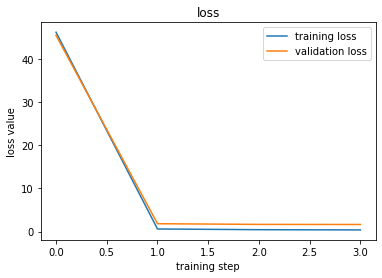

In [12]:
#绘图
plt.title('loss')
plt.xlabel('training step')
plt.ylabel('loss value')
plt.plot(range(len(training_losses)),training_losses,label='training loss')
plt.plot(range(len(validation_losses)),validation_losses,label='validation loss')
plt.legend(loc = "best")
plt.show()

In [13]:
validation_losses

[45.55715694493316, 1.816385945278783, 1.6608106052084395, 1.6415816818174505]